In [ ]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
file_path = '/content/mental_health_wearable_data.csv'
data2 = pd.read_csv(file_path)

In [ ]:
data2.head()

,Timestamp,EEG_Frequency_Bands,GSR_Values,Cognitive_State,Emotional_State,Student_ID,Age,Gender,Session_Type,Duration (minutes),Environmental_Context,Preprocessed_Features,Target
0,2025-01-01 10:00:00,"[7.400574384984986, 5.621240954745124, 4.62440...",1.376494,Distracted,Anxious,151,19,Female,Study,43,Library,"(0.09206977288455342, 0.3621872664986312)",0
1,2025-01-01 10:05:00,"[1.6898477932146672, 7.2616994947041125, 1.106...",0.084319,Focused,Stressed,150,20,Male,Test,49,Home,"(0.6630302454051626, 0.16534951688386967)",1
2,2025-01-01 10:10:00,"[0.2693319401287453, 8.909349692334239, 7.2444...",0.895629,Cognitive Overload,Anxious,173,24,Male,Test,56,Library,"(0.01057761975425231, 0.20044284523215694)",1
3,2025-01-01 10:15:00,"[6.080175212895389, 6.387554935291081, 9.09906...",0.386398,Focused,Anxious,171,22,Male,Relaxation,48,Library,"(0.2924924921884593, 0.8773068202243881)",1
4,2025-01-01 10:20:00,"[5.9007231710422525, 8.301537594579075, 4.4649...",1.186898,Focused,Anxious,131,22,Female,Relaxation,57,Home,"(0.7670629457831021, 0.5652674255918193)",0


In [ ]:
print("Shape:", data2.shape)

Shape: (500, 13)


In [ ]:
print("Columns:", list(data2.columns))

Columns: ['Timestamp', 'EEG_Frequency_Bands', 'GSR_Values', 'Cognitive_State', 'Emotional_State', 'Student_ID', 'Age', 'Gender', 'Session_Type', 'Duration (minutes)', 'Environmental_Context', 'Preprocessed_Features', 'Target']


In [ ]:
print("Duplicated rows:", data2.duplicated().sum())

Duplicated rows: 0


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              500 non-null    object 
 1   EEG_Frequency_Bands    500 non-null    object 
 2   GSR_Values             500 non-null    float64
 3   Cognitive_State        500 non-null    object 
 4   Emotional_State        500 non-null    object 
 5   Student_ID             500 non-null    int64  
 6   Age                    500 non-null    int64  
 7   Gender                 500 non-null    object 
 8   Session_Type           500 non-null    object 
 9   Duration (minutes)     500 non-null    int64  
 10  Environmental_Context  500 non-null    object 
 11  Preprocessed_Features  500 non-null    object 
 12  Target                 500 non-null    int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 50.9+ KB


In [ ]:
print(data2.count())

Timestamp                500
EEG_Frequency_Bands      500
GSR_Values               500
Cognitive_State          500
Emotional_State          500
Student_ID               500
Age                      500
Gender                   500
Session_Type             500
Duration (minutes)       500
Environmental_Context    500
Preprocessed_Features    500
Target                   500
dtype: int64


In [ ]:
data2 = data2.drop(data2.columns[0], axis=1)


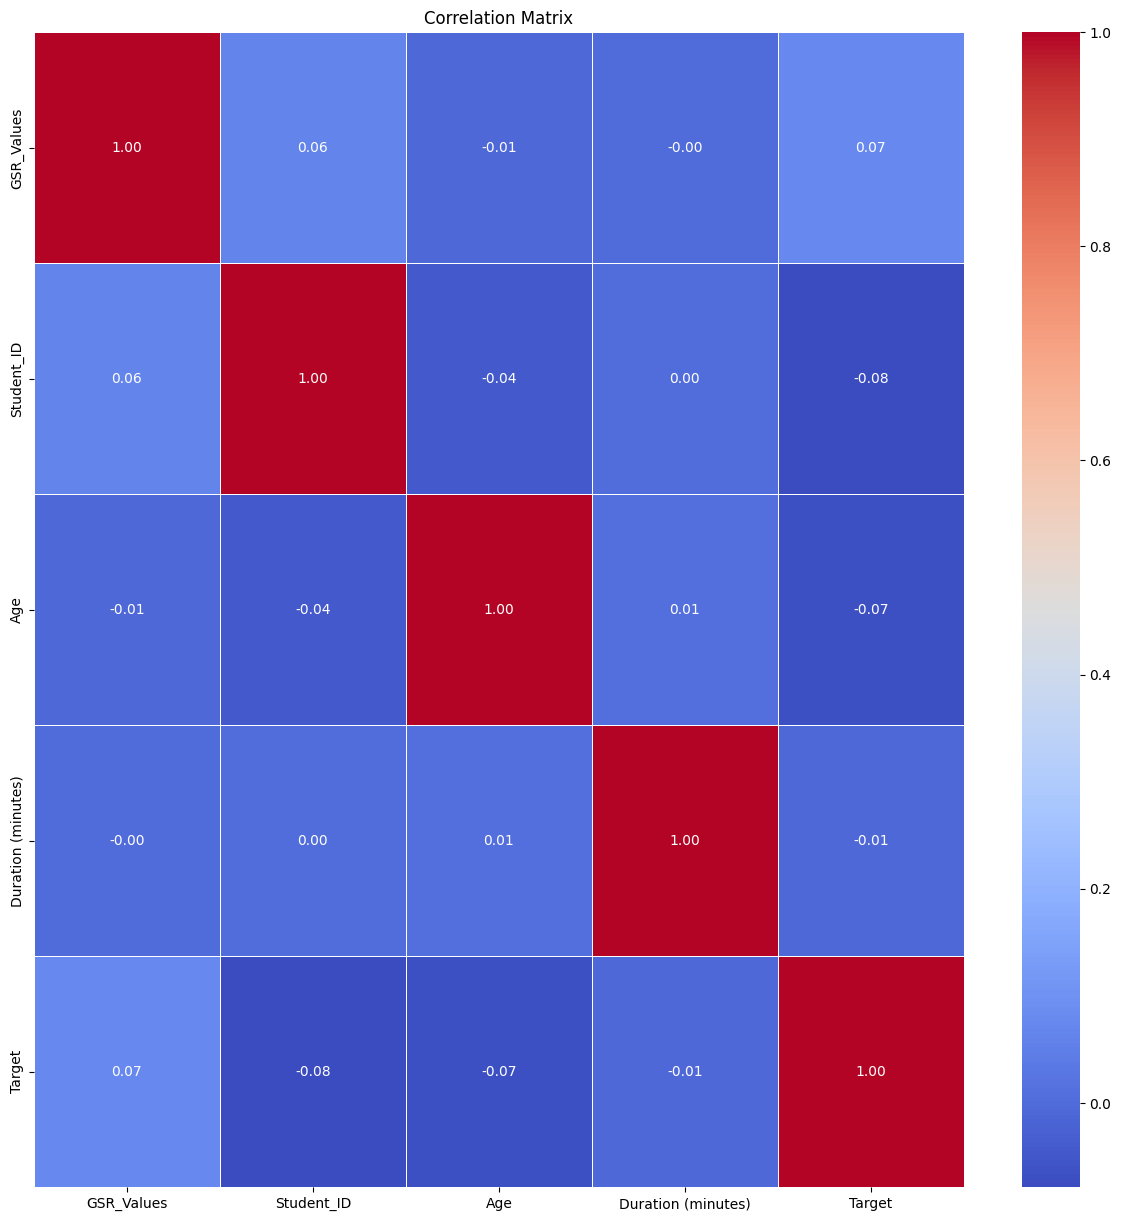

In [ ]:
# Correlation heatmap
plt.figure(figsize=(15, 15))
numeric_data = data2.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Expand structured columns
eeg_expanded = data2['EEG_Frequency_Bands'].apply(ast.literal_eval).apply(pd.Series)
eeg_expanded.columns = [f'EEG_Band_{i+1}' for i in eeg_expanded.columns]

In [ ]:
preprocessed_expanded = data2['Preprocessed_Features'].apply(ast.literal_eval).apply(pd.Series)
preprocessed_expanded.columns = ['Feature_1', 'Feature_2']

In [ ]:
#Encode categorical variables
categorical_cols = ['Cognitive_State', 'Emotional_State', 'Gender', 'Session_Type', 'Environmental_Context']
encoded_df = data2[categorical_cols].apply(LabelEncoder().fit_transform)

In [ ]:
# Select numerical columns
numerical_features = data2[['GSR_Values', 'Age', 'Duration (minutes)']]

In [ ]:
# Combine all features
X = pd.concat([eeg_expanded, preprocessed_expanded, numerical_features, encoded_df], axis=1)
y = data2['Target']

In [ ]:
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)


In [ ]:
# Feature selection/reduction
skb = SelectKBest(score_func=f_classif, k=10)
X_kbest = skb.fit_transform(X_scaled, y)

rf = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy')
X_rfecv = rfecv.fit_transform(X_scaled, y)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# All feature sets
feature_sets = {
    'No_Selection': X_scaled,
    'SelectKBest': X_kbest,
    'RFECV': X_rfecv,
    'PCA': X_pca
}

In [ ]:
# Train-test split options
splits = {
    '70-30': 0.3,
    '75-25': 0.25,
    '80-20': 0.2
}

In [ ]:
# Models
models = {
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

In [ ]:
results = []

for split_name, test_size in splits.items():
    for fs_name, X_fs in feature_sets.items():
        X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=test_size, random_state=42)

        for model_name, model in models.items():
            clf = model
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            print(f"Split: {split_name} | Feature Set: {fs_name} | Model: {model_name}")
            print("Accuracy:", acc)
            print("Confusion Matrix:\n", cm)
            print("Classification Report:\n", classification_report(y_test, y_pred))
            print("-" * 60)

            results.append({
                'Split': split_name,
                'Feature_Set': fs_name,
                'Model': model_name,
                'Accuracy': acc,
                'Precision': report['macro avg']['precision'],
                'Recall': report['macro avg']['recall'],
                'F1-Score': report['macro avg']['f1-score']
            })

# Save as DataFrame
results_df = pd.DataFrame(results)


Split: 70-30 | Feature Set: No_Selection | Model: SVM
Accuracy: 0.47333333333333333
Confusion Matrix:
 [[32 49]
 [30 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.40      0.45        81
           1       0.44      0.57      0.50        69

    accuracy                           0.47       150
   macro avg       0.48      0.48      0.47       150
weighted avg       0.48      0.47      0.47       150

------------------------------------------------------------
Split: 70-30 | Feature Set: No_Selection | Model: RandomForest
Accuracy: 0.5133333333333333
Confusion Matrix:
 [[44 37]
 [36 33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.54      0.55        81
           1       0.47      0.48      0.47        69

    accuracy                           0.51       150
   macro avg       0.51      0.51      0.51       150
weighted avg       0.51      0.51      0

In [ ]:
# Pivot Table Summary
pivot_df = results_df.pivot_table(index=['Feature_Set', 'Model'], columns='Split', values='Accuracy')
print("\nSummary of Accuracy Results:\n")
print(pivot_df)



Summary of Accuracy Results:

Split                         70-30  75-25  80-20
Feature_Set  Model                               
No_Selection RandomForest  0.513333  0.496   0.51
             SVM           0.473333  0.504   0.50
PCA          RandomForest  0.486667  0.504   0.48
             SVM           0.460000  0.480   0.50
RFECV        RandomForest  0.566667  0.584   0.54
             SVM           0.500000  0.496   0.50
SelectKBest  RandomForest  0.540000  0.560   0.59
             SVM           0.560000  0.544   0.53


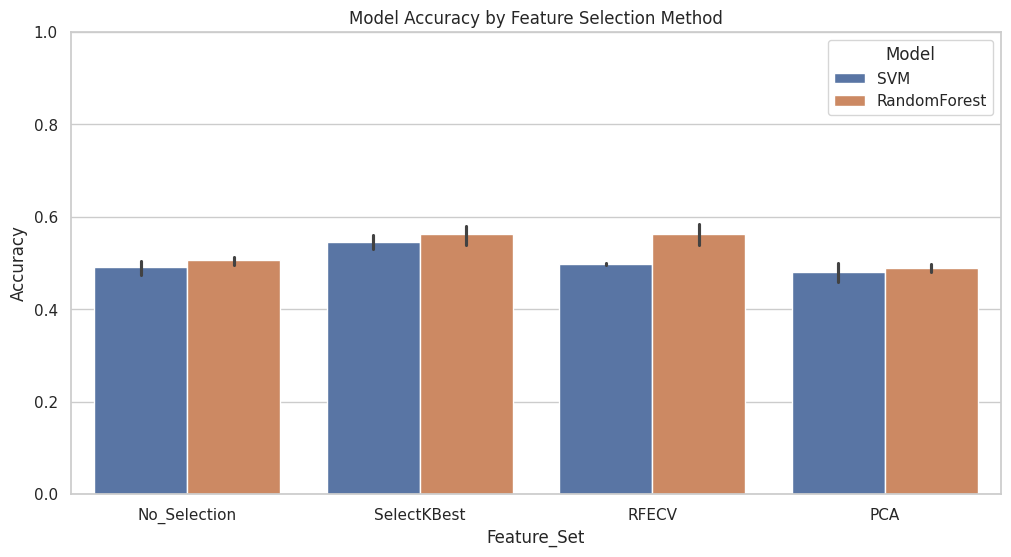

In [ ]:
# Barplot of results
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Feature_Set', y='Accuracy', hue='Model')
plt.title('Model Accuracy by Feature Selection Method')
plt.ylim(0, 1)
plt.show()

In [ ]:
# K-Fold Evaluation
print("\n\n===== K-FOLD CROSS VALIDATION RESULTS =====")
kf_results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fs_name, X_fs in feature_sets.items():
    for model_name, model in models.items():
        clf = model
        scores = cross_val_score(clf, X_fs, y, cv=kf)
        y_pred = cross_val_predict(clf, X_fs, y, cv=kf)
        report = classification_report(y, y_pred, output_dict=True)

        kf_results.append({
            'Feature_Set': fs_name,
            'Model': model_name,
            'Accuracy': np.mean(scores),
            'Precision': report['macro avg']['precision'],
            'Recall': report['macro avg']['recall'],
            'F1-Score': report['macro avg']['f1-score']
        })

# Show K-Fold results
kf_results_df = pd.DataFrame(kf_results)
print(kf_results_df)




===== K-FOLD CROSS VALIDATION RESULTS =====
    Feature_Set         Model  Accuracy  Precision    Recall  F1-Score
0  No_Selection           SVM     0.508   0.507963  0.507960  0.507929
1  No_Selection  RandomForest     0.494   0.493697  0.493776  0.492292
2   SelectKBest           SVM     0.526   0.525964  0.525904  0.525679
3   SelectKBest  RandomForest     0.560   0.560096  0.559881  0.559549
4         RFECV           SVM     0.530   0.530670  0.529632  0.525810
5         RFECV  RandomForest     0.544   0.544039  0.543881  0.543533
6           PCA           SVM     0.504   0.503992  0.503992  0.503992
7           PCA  RandomForest     0.544   0.543985  0.543929  0.543818
